In [214]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
import math

plt.style.use('ggplot')

### Белый шум

In [450]:
n = 1000
t0 = 0
t1 = 10

t = np.linspace(t0, t1, n)

normal_noise = [np.random.normal() for _ in range(n)]
uniform_noise = [np.random.uniform(-1, 1) for _ in range(n)]

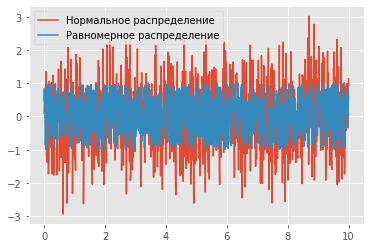

In [452]:
plt.plot(t, normal_noise, label='Нормальное распределение')
plt.plot(t, uniform_noise, label='Равномерное распределение')
plt.legend();

### Параметры процесса

In [348]:
σ = 1
α = 1
D = 0.5

m = 100
n = 200
t0 = 0
t1 = 10
dt = (t1 - t0) / n

#### Автокорреляционная функция

In [481]:
def get_R(D, α):
    def R(τ):
        return D * np.exp(-α * abs(τ)) * (1 - α * abs(τ))
    
    return R

#### Импульсная харастеристика фильтра

In [349]:
def get_h(D, α, σ):
    def h(τ):
        return np.exp(-α * τ) * (1 - α * τ) * np.sqrt((2 * D * α) / (math.pi * σ**2))
    
    return h

In [350]:
h = get_h(D, α, σ)

### Построим реализации процесса

In [721]:
def get_realization(n, h, d, hlim=1e-20):
    x = [np.random.uniform(-1, 1) for _ in range(n)]
    y = []
    
    for j in range(n):
        cur_y = 0
        for i in range(j + 1):
            cur_val = h(dt * i) * x[j - i]
            
            if abs(cur_val) < hlim:
                break
            
            cur_y += cur_val
         
        y.append(cur_y)
    
    return y

def get_realizations(t0, t1, n, m, h):
    realizations = []
    t = np.linspace(t0, t1, n)

    for q in range(m):
        y = get_realization(n, h, dt)

        realizations.append(y)
    
    return t, realizations

In [722]:
t, realizations = get_realizations(t0, t1, n, m, h)

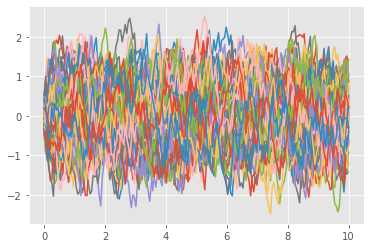

In [723]:
for y in realizations:
    plt.plot(t, y)

### Усредненные по реализациям матожидания

Для каждого дискретного момента времени посчитаем матожидание по всем реализациям процесса в этот момент времени

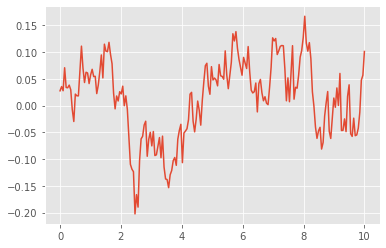

In [724]:
def get_expectations(realizations, n):
    realizations = np.array(realizations)
    return [np.mean(realizations[:, i]) for i in range(n)]

mys = get_expectations(realizations, n)
plt.plot(t, mys);

### Матожидание для эргодического процесса

In [725]:
def get_ergodic_exp(y, T, dt):
    n = len(y)
    
    return dt / T * sum(y)

def plot_ergodic(dt, h):
    my_erg = []
    T_vals = [5, 10, 20, 30, 50, 100, 200, 500, 1000]
    
    for T in T_vals:
        big_t, realizations_big_t = get_realizations(0, T, T * 10, 1, h)
        my_erg.append(get_ergodic_exp(realizations_big_t[0], T, 0.1))
    
    return T_vals, my_erg

In [726]:
T_vals, my_erg = plot_ergodic(dt, h)

In [727]:
for i in range(len(T_vals)):
    print('Матожидание случайного процесса при T = {:3}: {:.5}'.format(T_vals[i], my_erg[i]))

Матожидание случайного процесса при T =   5: 0.18042
Матожидание случайного процесса при T =  10: -0.30306
Матожидание случайного процесса при T =  20: 0.20344
Матожидание случайного процесса при T =  30: 0.054594
Матожидание случайного процесса при T =  50: -0.082885
Матожидание случайного процесса при T = 100: -0.091811
Матожидание случайного процесса при T = 200: 0.11305
Матожидание случайного процесса при T = 500: 0.041467
Матожидание случайного процесса при T = 1000: 0.026842


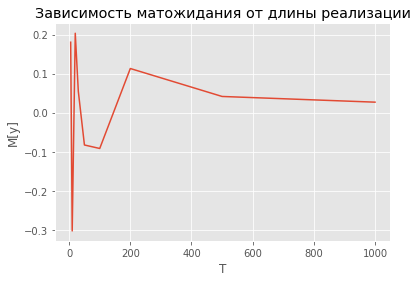

In [728]:
plt.title('Зависимость матожидания от длины реализации')
plt.ylabel('M[y]')
plt.xlabel('T')
plt.plot(T_vals, my_erg);

### Доверительные интрвалы для матожиданий

Построим доверительные интервалы для матожиданий в каждый дискретный момент времени

In [729]:
from statlib.metrics import expectation, dispersion, get_exp_interval
import scipy

def get_expectaion_intervals(realizations, n, prob):
    realizations = np.array(realizations)
    my_l = []
    my_r = []
    mys = []
    
    for i in range(n):
        y_ti = realizations[:, i]
        my = expectation(y_ti)
        σ = math.sqrt(dispersion(y_ti))
        
        my_exp_len = get_exp_interval(σ, prob, len(y_ti))
        
        mys.append(my)
        my_l.append(my - my_exp_len)
        my_r.append(my + my_exp_len)
    
    return mys, my_l, my_r

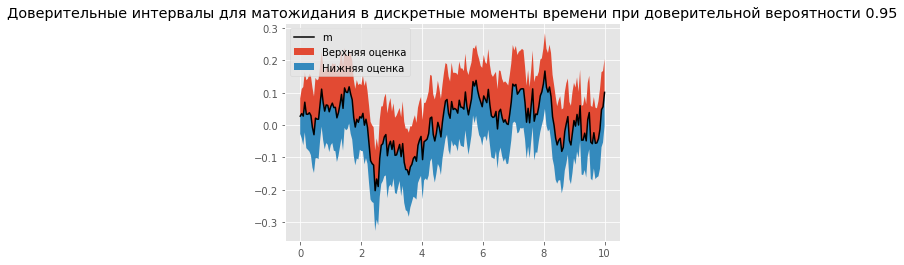

In [730]:
prob = 0.95
mys, my_l, my_r = get_expectaion_intervals(realizations, n, prob)

plt.title('Доверительные интервалы для матожидания в дискретные моменты времени при доверительной вероятности {}'.format(prob))
plt.fill_between(t, mys, my_r, label='Верхняя оценка')
plt.plot(t, mys, color='black', label='m')
plt.fill_between(t, mys, my_l, label='Нижняя оценка')
plt.legend();

### Доверительный интрвалы для дисперсий

Построим доверительные интервалы для дисперсий в каждый дискретный момент времени

In [731]:
from statlib.metrics import get_dispersion_borders_known
import scipy

def get_dispersion_intervals(realizations, n, α):
    realizations = np.array(realizations)
    dy_l = []
    dy_r = []
    dys = []
    
    for i in range(n):
        y_ti = realizations[:, i]
        my = expectation(y_ti)
        dy = dispersion(y_ti)
        σ = math.sqrt(dy)
        
        dy_len = get_exp_interval(σ, 1 - α, len(y_ti))
        
        dys.append(dy)
        dy_l.append(dy - dy_len)
        dy_r.append(dy + dy_len)
    
    return dys, dy_l, dy_r

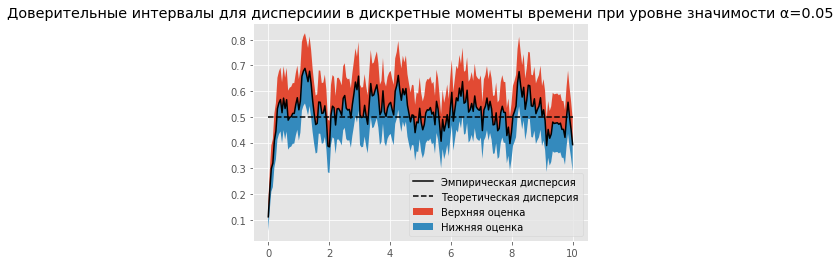

In [732]:
dy_alpha = 0.05
dys, dy_l, dy_r = get_dispersion_intervals(realizations, n, dy_alpha)

plt.title('Доверительные интервалы для дисперсиии в дискретные моменты времени при уровне значимости α={}'.format(dy_alpha))
plt.hlines(D, t0, t1, linestyles='dashed', label='Теоретическая дисперсия')
plt.fill_between(t, dys, dy_r, label='Верхняя оценка')
plt.plot(t, dys, color='black', label='Эмпирическая дисперсия')
plt.fill_between(t, dys, dy_l, label='Нижняя оценка')
plt.legend();

### Построим эмпирическую автокорреляционную функцию

In [733]:
def emp_R(y, dt, n):
    r_vals = []
    for k in range(n):
        lim = n - k
        r_vals.append((1 / lim) * sum(y[i] * y[i + k] for i in range(lim)))
    
    return r_vals
  
def theor_R(R, dt, n):
    return [R(dt * i) for i in range(n)]

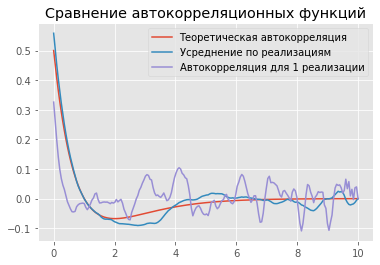

In [734]:
R = get_R(D, α)

# усреднение по реализациям
rys = np.array([emp_R(ys[i], dt, n) for i in range(m)])

emp_r = [np.mean(rys[:, i]) for i in range(n)] 
th_R = theor_R(R, dt, n)

plt.title('Сравнение автокорреляционных функций')
plt.plot(t, th_R, label='Теоретическая автокорреляция')
plt.plot(t, emp_r, label='Усреднение по реализациям')
plt.plot(t, rys[0], label='Автокорреляция для 1 реализации')
plt.legend();

### Оценка отклонения эмпирической автокорреляционной функции

In [735]:
def ek(R_th, R_emp, k):
    return R_emp[k] - R_th[k]

def autocorr_M(R_th, R_emp):
    n = len(R_th)
    return np.mean([ek(R_th, R_emp, k) for k in range(n)])
    
def autocorr_D(R_th, R_emp):
    n = len(R_th)
    mr = autocorr_M(R_th, R_emp)
    return np.mean([(ek(R_th, R_emp, k) - mr)**2 for k in range(n)])

In [736]:
print('Дисперсия отклонения автокорреляционной функции:', autocorr_D(th_R, emp_r))
print('Матожидание отклонения автокорреляционной функции:', autocorr_M(th_R, emp_r))

Дисперсия отклонения автокорреляционной функции: 0.0004081369762337249
Матожидание отклонения автокорреляционной функции: -0.002186722144004233


In [242]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

import random


class StationarityTests:
    def __init__(self, significance=0.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults=True):
        # Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')

        self.pValue = adfTest[1]

        if (self.pValue < self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False

        if printResults:
            dfResults = pd.Series(adfTest[0:4],
                                  index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])
            # Add Critical Values
            for key, value in adfTest[4].items():
                dfResults['Critical Value (%s)' % key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

In [418]:
x = [np.random.normal() for _ in range(n)]
y = [sum(h(dt * (j - i)) * x[j - i] for i in range(min(100, j))) for j in range(n)]

sTest = StationarityTests()
sTest.ADF_Stationarity_Test(y, True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

print('\n'*5)

sTest.ADF_Stationarity_Test(x, True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.861259
P-Value                   0.002339
# Lags Used              18.000000
# Observations Used     981.000000
Critical Value (1%)      -3.437033
Critical Value (5%)      -2.864491
Critical Value (10%)     -2.568341
dtype: float64
Is the time series stationary? True






Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -31.198772
P-Value                   0.000000
# Lags Used               0.000000
# Observations Used     999.000000
Critical Value (1%)      -3.436913
Critical Value (5%)      -2.864437
Critical Value (10%)     -2.568313
dtype: float64
Is the time series stationary? True
